### 利用Dreambooth微调实现更加优秀的Text2Image Pipeline

In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

In [2]:
# 导入diffusers组件
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionDepth2ImgPipeline
)

In [3]:
# 定义一个打开图片的函数，并将返回的字节通过PIL显示出来
def open_image(path):
    response = open(path, 'rb')
    img = Image.open(BytesIO(response.read())).convert('RGB')
    return img

In [4]:
img_path = "./data/overture-creations-5sI6fQgYIuo.png"
mask_path = "./data/overture-creations-5sI6fQgYIuo_mask.png"

In [5]:
init_image = open_image(img_path).resize((512, 512))
mask = open_image(mask_path).resize((512, 512))

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# 登录huggingface
from huggingface_hub import notebook_login
notebook_login()

In [8]:
# 载入管线
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id,revision='fp16',torch_dtype=torch.float16).to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# 开启注意力切分，以降低显存占用
pipe.enable_attention_slicing()

In [10]:
# 给生成器设置一个随机种子，以便每次生成的结果都不一样
generator = torch.Generator(device=device).manual_seed(42)

In [12]:
torch.set_float32_matmul_precision('high')

In [13]:
# 执行预测
pipe_output = pipe(
    prompt = "Palette knife painting of an autumn cityscape",
    # 设置负向提示词
    negative_prompt = "Oversaturated,blurry,low quality",
    # 设置大小
    height=480,width=640,
    guidance_scale = 8,
    num_inference_steps = 35,
    generator=generator
)

  0%|          | 0/35 [00:00<?, ?it/s]

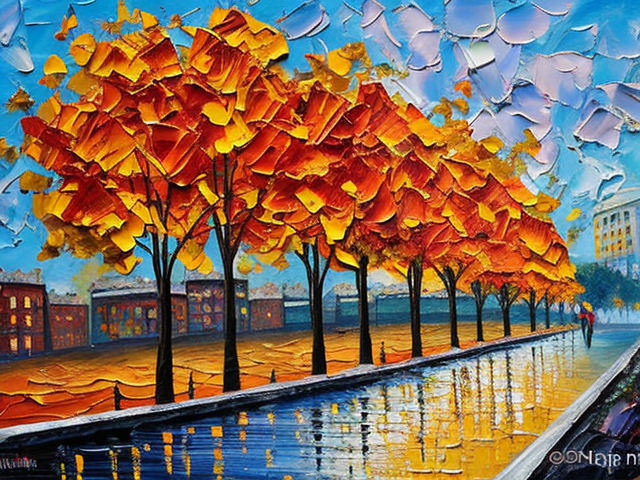

In [14]:
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

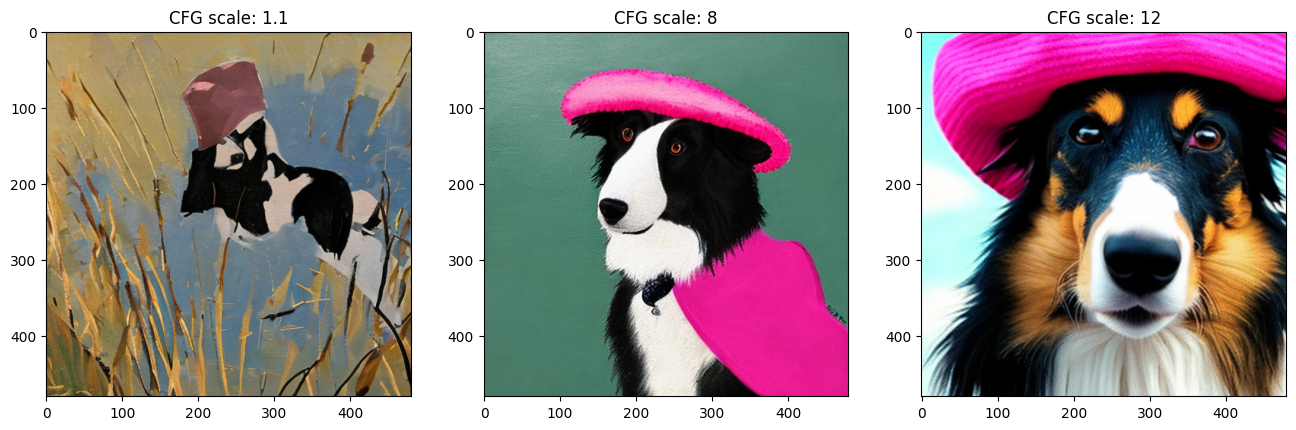

In [15]:
# 利用CFG（Class Free Guidance，无类别监督引导）进行图像生成
cfg_scales = [1.1,8,12]
prompt = "A collie with a pink hat"
fig,axs = plt.subplots(1,len(cfg_scales),figsize=(16,5))
for i,ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,

        guidance_scale = cfg_scales[i],
        num_inference_steps = 35,
        generator=generator
    ).images[0]
    ax.imshow(im);ax.set_title(f"CFG scale: {cfg_scales[i]}")

In [22]:
list(pipe.components.keys())

['vae',
 'text_encoder',
 'tokenizer',
 'unet',
 'scheduler',
 'safety_checker',
 'feature_extractor']